In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from scipy_mod import de_generator
from scipy.stats import qmc, shapiro

In [2]:
dataset = 'Indoorloc'
task = 1 # only relevant for Indoorloc (1) and telemonitoring (2), ignored for other datasets

from_raw = False
if from_raw:
    data = pd.read_csv(f"datasets\\{dataset}\\{dataset}.csv")
    X = data.iloc[:, :-1].to_numpy()
    y = data.iloc[:,-1].to_numpy()
    #np.save(f"datasets\\{dataset}\\X.npy", X)
    #np.save(f"datasets\\{dataset}\\y.npy", y)

else:
    X = np.load(os.path.join("datasets", dataset, "X.npy"))
    if dataset in ['Indoorloc', 'telemonitoring']:
        y = np.load(os.path.join("datasets", dataset, f"y{task}.npy"))
    else:
        y = np.load(os.path.join("datasets", dataset, f"y.npy"))

print(X.shape, y.shape)

(19937, 520) (19937,)


In [7]:
# simple sklearn model

# standardize y to mean 0, std 1
y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))
X_scaled = preprocessing.StandardScaler().fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled.reshape(-1), train_size=5000, random_state=42)

# scale X values
#scaler = preprocessing.StandardScaler()
#scaler.fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

run_RF = False
if run_RF:
    model = RandomForestRegressor() #RandomForestRegressor() #KernelRidge()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    plt.scatter(y_test, y_pred)

# test for data normality with Shapiro Wilk test
for i in range(X_train.shape[1]):
    print(shapiro(X_train[:, i]))

In [3]:
# Train teacher model
class Regressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Regressor, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.hidden(x)
        x = nn.Tanh()(x)
        x = self.output(x)
        return x

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = nn.Tanh()(x)
        x = self.output(x)
        return x

In [4]:
def train_epoch(model, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = 0.0
    for x, y in dataloader:
        y_pred = model(x.float().to(device))
        loss = torch.nn.MSELoss()(y_pred.reshape(-1), y.float().to(device))
        train_loss += loss.cpu().item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss / len(dataloader)

def valid_epoch(model, device, dataloader):
    # Set train mode for both the encoder and the decoder
    model.eval()
    valid_loss = 0.0
    for x, y in dataloader:
        y_pred = model(x.float().to(device))
        loss = torch.nn.MSELoss()(y_pred.reshape(-1), y.float().to(device))
        valid_loss += loss.cpu().item()
    return valid_loss / len(dataloader)

In [5]:
def train_model(model, train_loader, valid_loader, lr, device, save_path, epochs=100):
    model = model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-6)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5)

    bar = tqdm(range(epochs))
    train_losses = []
    valid_losses = []
    min_val_loss = np.inf
    patience = 50
    patience_step = 0
    for epoch in bar:
        train_loss = train_epoch(model, device, train_loader, optimizer)
        valid_loss = valid_epoch(model, device, valid_loader)
        bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}  valid loss {valid_loss:.6f}  valid RMSE {np.sqrt(valid_loss):.5f}")
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss < min_val_loss:
            min_val_loss = valid_loss
            torch.save(model.state_dict(), save_path)
        else:
            scheduler.step(valid_loss)
            patience_step += 1
        if patience_step > patience:
            break
    return train_losses, valid_losses

In [8]:
save_path = f"teacher_models\\teacher_test.pt"
model = Regressor(input_size=X.shape[1], hidden_size=500)
lr=0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, train_size=0.1, random_state=42)

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, drop_last=False)

In [9]:
retrain = False
if retrain:
    train_losses, valid_losses = train_model(model, train_loader, valid_loader, lr, device, save_path, epochs=250)
    plt.plot(np.arange(len(train_losses)), train_losses, label='train_loss')
    plt.plot(np.arange(len(valid_losses)), valid_losses, label='valid_loss')
    plt.legend()
else:
    model.load_state_dict(torch.load(save_path))

In [10]:
model.load_state_dict(torch.load(save_path))
model.eval().to(device)
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        pred = model(x.float().to(device))
        pred = pred.cpu().detach().item()
        y_pred.append(pred)
y_pred = np.array(y_pred).reshape(-1)

print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")

R2 score: 0.9928372506079745
RMSE: 0.08465063644601518


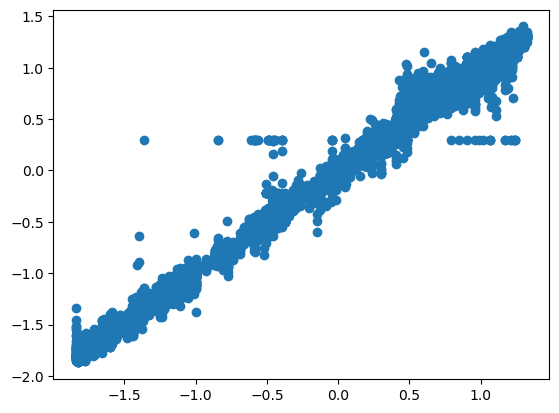

In [11]:
plt.scatter(y_test, y_pred)

### Teacher (500 hidden neurons) model performance measured by RMSE

| Dataset        | Kang 2021 | Ours (RF) | Ours (NN) |    Remarks    |      Optimizer     |    Lr    |    Scheduler  | Epochs |      
|----------------|:---------:|:---------:|:---------:|:-------------:|:------------------:|:--------:|:-------------:|:------:| 
| Bikesharing    | 0.012     |     -     |     -     | Data leakage  |                    |          |               |        |
| Compactiv      | 0.142     |   0.136   |  0.145    |               |       RMSprop      | 0.0005   | Plateau 0.5   |   150  |
| Cpusmall       | 0.165     |   0.155   |  0.164    |               |       RMSprop      | 0.0005   | Plateau 0.5   |   150  |
| CTScan         | 0.115     |   0.173   |  0.092    |               |       RMSprop      | 0.0005   | Plateau 0.5   |   150  |
| Indoorloc      | 0.096     |   0.090   |  0.093    |               |       RMSprop      | 0.0005   | Plateau 0.5   |   150  |
| Mv             | 0.016     |   0.016   |  0.017    |               |       RMSprop      | 0.001    | Plateau 0.5   |   150  |
| Pole           | 0.149     |   0.143   |  0.146    |               |       RMSprop      | 0.001    | Plateau 0.5   |   150  |
| Puma32h        | 0.241     |   0.262   |  0.284    |               | RMSprop decay=1e-6 | 0.001    | Plateau 0.5   |   150  |
| Telemonitoring | 0.206     |     -     |     -     | Data leakage  |                    |          |               |        |

In [12]:
# Train generator

def generator_loss(x: torch.Tensor, teacher_model, student_model):
    teacher_model.eval().to(device)
    student_model.eval().to(device)
    teacher_label = teacher_model(x.float().to(device))
    student_pred = student_model(x.float().to(device))
    return -(teacher_label - student_pred)**2, student_pred

def teacher_pred(x: np.array, teacher_model, student_model):
    x = torch.from_numpy(x)
    teacher_model.eval().to(device)
    student_model.eval().to(device)
    
    with torch.no_grad():
        teacher_label = teacher_model(x.float().to(device))
        student_pred = student_model(x.float().to(device))
    teacher_label = teacher_label.cpu().detach().numpy()
    student_pred = student_pred.cpu().detach().numpy()
    return -(teacher_label - student_pred)**2

In [13]:
class FunctionWrapper(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, m, d):
        super().__init__()
        weights = torch.randn(m, d).to(device)
        self.weights = nn.Parameter(weights.float())
        
    def forward(self, teacher_model, student_model):
        teacher_model.eval().to(device)
        student_model.eval().to(device)
        teacher_label = teacher_model(self.weights.to(device))
        student_pred = student_model(self.weights.to(device))
        return -(teacher_label - student_pred)**2, student_pred

  0%|                                                                 | 0/501 [00:00<?, ?it/s]
 EPOCH 1/501 	 train loss 2.859207  valid RMSE 0.43281:   0%|        | 0/501 [00:00<?, ?it/s]
 EPOCH 1/501 	 train loss 2.859207  valid RMSE 0.43281:   0%| | 1/501 [00:00<01:59,  4.18it/s
 EPOCH 2/501 	 train loss 1.856128  valid RMSE 0.32875:   0%| | 1/501 [00:00<01:59,  4.18it/s
 EPOCH 2/501 	 train loss 1.856128  valid RMSE 0.32875:   0%| | 2/501 [00:00<01:48,  4.62it/s
 EPOCH 3/501 	 train loss 1.134580  valid RMSE 0.44517:   0%| | 2/501 [00:00<01:48,  4.62it/s
 EPOCH 3/501 	 train loss 1.134580  valid RMSE 0.44517:   1%| | 3/501 [00:00<01:42,  4.87it/s
 EPOCH 4/501 	 train loss 0.633135  valid RMSE 0.54371:   1%| | 3/501 [00:00<01:42,  4.87it/s
 EPOCH 4/501 	 train loss 0.633135  valid RMSE 0.54371:   1%| | 4/501 [00:00<01:40,  4.95it/s
 EPOCH 5/501 	 train loss 0.456365  valid RMSE 0.55106:   1%| | 4/501 [00:01<01:40,  4.95it/s
 EPOCH 5/501 	 train loss 0.456365  valid RMSE 0.55106:   1

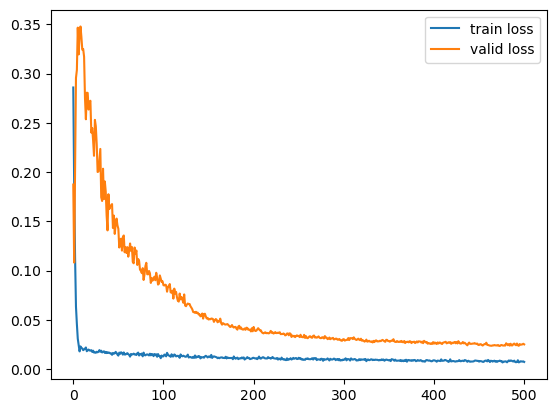

In [48]:
# Train student with baseline method 
retrain = True
continue_training = False
model.eval()
epochs = 501
ns = 10
m = 50
bar = tqdm(range(epochs))
bounds = np.array(list(zip(np.min(X_test, axis=0), np.max(X_test, axis=0))))
student_size = 25
student_model = Regressor(input_size=X.shape[1], hidden_size=student_size)
student_save_path = f"student_models\\baseline_test.pt"
if continue_training:
    student_model.load_state_dict(torch.load(student_save_path))

lr = 0.001
optimizer = torch.optim.RMSprop(student_model.parameters(), lr=lr, weight_decay=1e-6)

train_losses = []
valid_losses = []
min_val_loss = np.inf

sampler = qmc.Halton(X_test.shape[1]) #LatinHypercube
bounds = np.array(list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)+0.01)))

if retrain:
    for epoch in bar:
        train_loss = 0.0
        for i in range(ns):
            # generate synthetic data
            xp = np.random.normal(loc=0.0, scale=1.0, size=(m, len(bounds)))
            #xp = sampler.random(n=m)
            #xp = qmc.scale(xp, bounds[:,0], bounds[:,1])

            samples = torch.from_numpy(xp).float()
            with torch.no_grad():
                model.eval().to(device)
                teacher_label = model(samples.to(device))

            # train student model
            student_model.train().to(device)
            student_pred = student_model(samples.to(device))
            loss = torch.nn.MSELoss()(student_pred.reshape(-1), teacher_label.reshape(-1))
            train_loss += loss.cpu().item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        valid_loss = valid_epoch(student_model, device, valid_loader)
        train_losses.append(train_loss/ns)
        valid_losses.append(valid_loss)
        bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}  valid RMSE {np.sqrt(valid_loss):.5f}")
        if valid_loss < min_val_loss:
            torch.save(student_model.state_dict(), student_save_path)
            min_val_loss = valid_loss

    plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')
    plt.plot(np.arange(len(valid_losses)), valid_losses, label='valid loss')
    plt.legend()

snapshot = epoch

 EPOCH 2/2 	 train loss -0.019360: 100%|██████████████████████| 2/2 [00:00<00:00, 153.96it/s]


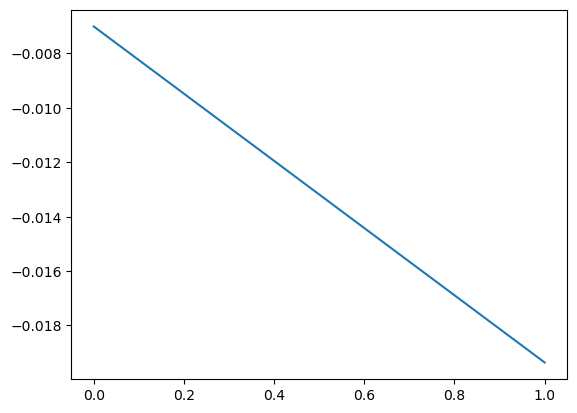

In [57]:
# direct optimization on generator loss wrt input x
model.eval()
epochs = 2
m = 50
train_losses = []
fun = FunctionWrapper(m, X_test.shape[1])
optimizer_direct = torch.optim.RMSprop(fun.parameters(), lr=0.1, weight_decay=1e-5)
bar = tqdm(range(epochs))
for epoch in bar:
    loss, student_pred = fun(model, student_model)
    loss = torch.mean(loss + 1e-5 * student_pred**2)

    optimizer_direct.zero_grad()
    loss.backward()
    optimizer_direct.step()
    train_loss = loss.cpu().item()
    train_losses.append(train_loss)
    bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss:.6f}")
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss') 

 EPOCH 2/2 	 train loss -0.042886: 100%|███████████████████████| 2/2 [00:00<00:00, 69.67it/s]


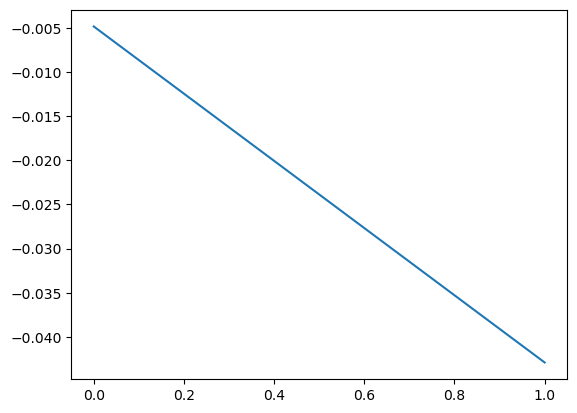

In [58]:
# train generator to generate x that give large generator loss
continue_training = False
model.eval()
epochs = 2
ns = 1
m = 50
bar = tqdm(range(epochs))
generator = Generator(50, 500, X_test.shape[1]).to(device)
if continue_training:
    generator.load_state_dict(torch.load(generator_save_path))

optimizer = torch.optim.RMSprop(generator.parameters(), lr=0.001, weight_decay=1e-6)

train_losses = []
generator.train()
clamp_min, clamp_max = torch.from_numpy(bounds[:,0]).to(device), torch.from_numpy(bounds[:,1]).to(device)
for epoch in bar:
    train_loss = 0.0
    for i in range(ns):
        # generate synthetic data
        xg = np.random.normal(loc=0.0, scale=1.0, size=(m, 50))
        xg = torch.from_numpy(xg).float()
        xg = generator(xg.to(device))
        #xg = torch.clamp(xg, clamp_min, clamp_max)
        loss, student_pred = generator_loss(xg, model, student_model)
        loss = torch.mean(loss + 1e-5 * torch.norm(xg, dim=1) + 1e-5 * student_pred**2)
        train_loss += loss.cpu().item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(train_loss/ns)
    bar.set_description(f"\n EPOCH {epoch + 1}/{epochs} \t train loss {train_loss/ns:.6f}")
plt.plot(np.arange(len(train_losses)), train_losses, label='train loss')

In [65]:
# random sample (normal)
xg_normal = np.random.normal(loc=0.0, scale=1.0, size=(m, len(bounds)))
loss_S_normal = -teacher_pred(xg_normal, model, student_model)

# random sample (qmc)
sampler = qmc.LatinHypercube(X_test.shape[1])
xg_lhs = sampler.random(n=m)
loss_S_lhs = -teacher_pred(xg_lhs, model, student_model)

# generator
generator.eval()
with torch.no_grad():
    xg_generator = torch.randn(m, 50).to(device)
    xg_generator = generator(xg_generator).cpu().numpy()
loss_S_generator = -teacher_pred(xg_generator, model, student_model)

# direct optimization (gradient descent)
xg_direct = nn.utils.parameters_to_vector(fun.weights).view(m, -1).detach().cpu().numpy()
loss_S_direct = -teacher_pred(xg_direct, model, student_model)

# direct optimization (DE)

bounds = np.array(list(zip(np.min(X_train, axis=0), np.max(X_train, axis=0)+0.01)))
xg_direct_de = np.random.normal(loc=0.0, scale=1.0, size=(m, len(bounds)))
_, xg_direct_de, _ = de_generator(teacher_pred, bounds, args=(model, student_model), init=xg_direct_de, strategy='best1bin', maxiter=2, polish=False)
loss_S_direct_de = -teacher_pred(xg_direct_de, model, student_model)

In [66]:
plot_data = {'random sample (gaussian)'               : loss_S_normal.reshape(-1),
             'random sample (latin hypercube)'        : loss_S_lhs.reshape(-1), 
             'generator method'                       : loss_S_generator.reshape(-1), 
             'direct optimization (gradient descent)' : loss_S_direct.reshape(-1), 
             'direct optimization (metaheuristics)'   : loss_S_direct_de.reshape(-1)}
plot_data = pd.DataFrame.from_dict(plot_data)

In [67]:
plot_data.head()

,random sample (gaussian),random sample (latin hypercube),generator method,direct optimization (gradient descent),direct optimization (metaheuristics)
0,0.017421,0.000121,0.293034,0.078380,0.166047
1,0.007859,0.000133,0.020059,0.034986,0.007560
2,0.021833,0.002713,0.273512,0.020598,0.017704
3,0.001770,0.000442,0.263472,0.003042,0.058890
4,0.007467,0.000748,0.240071,0.094834,0.009940


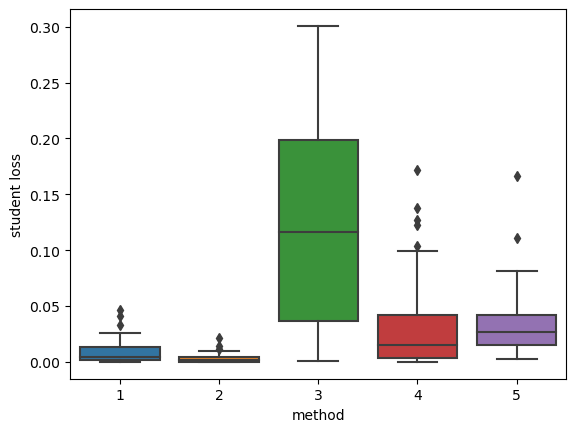

In [68]:
import seaborn as sns
f, ax = plt.subplots(1)
sns.boxplot(data=plot_data, ax=ax)
ax.set_xticklabels([1,2,3,4,5])
ax.set_ylabel("student loss")
ax.set_xlabel("method")
'''
plt.scatter(None, None, label='random sample (gaussian)')
plt.scatter(None, None, label='random sample (latin hypercube)')
plt.scatter(None, None, label='generator method')
plt.scatter(None, None, label='direct optimization (gradient descent)')
plt.scatter(None, None, label='direct optimization (metaheuristics)')
plt.legend()
'''
plt.savefig(f"plots\\synthetic_data_student_loss_{snapshot}.png")

In [69]:
reducer = umap.UMAP()
idx = np.random.choice(np.arange(len(X_train)), 200, replace=False)
reducer.fit(X_train[idx])

emb_train = reducer.transform(X_train[idx])
#emb_normal = reducer.transform(xg_normal)
#emb_lhs = reducer.transform(xg_lhs)
emb_generator = reducer.transform(xg_generator)
emb_direct = reducer.transform(xg_direct)
#emb_direct_de = reducer.transform(xg_direct_de)

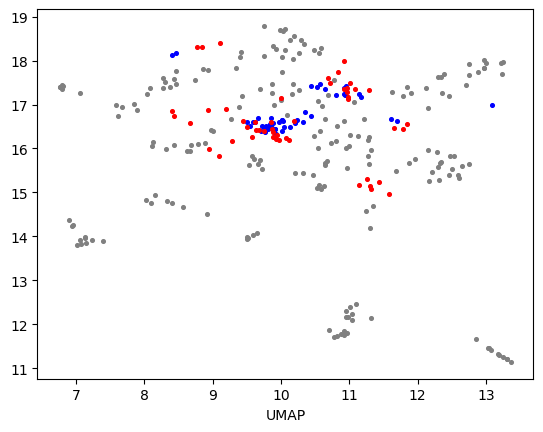

In [70]:
s = 7
plt.scatter(emb_train[:,0], emb_train[:,1], label='real data', s=s, c='gray')
#plt.scatter(emb_normal[:,0], emb_normal[:,1], label='random sample (gaussian)', s=s)
#plt.scatter(emb_lhs[:,0], emb_lhs[:,1], label='random sample (latin hypercube)', s=s)
plt.scatter(emb_generator[:,0], emb_generator[:,1], label='generator method', s=s, c='blue')
plt.scatter(emb_direct[:,0], emb_direct[:,1], label='direct optimization (gradient descent)', s=s, c='red')
#plt.scatter(emb_direct_de[:,0], emb_direct_de[:,1], label='direct optimization (metaheuristics)', s=s)
plt.xlabel("UMAP")
#plt.legend()
plt.savefig(f"plots\\synthetic_data_UMAP_{snapshot}.png")

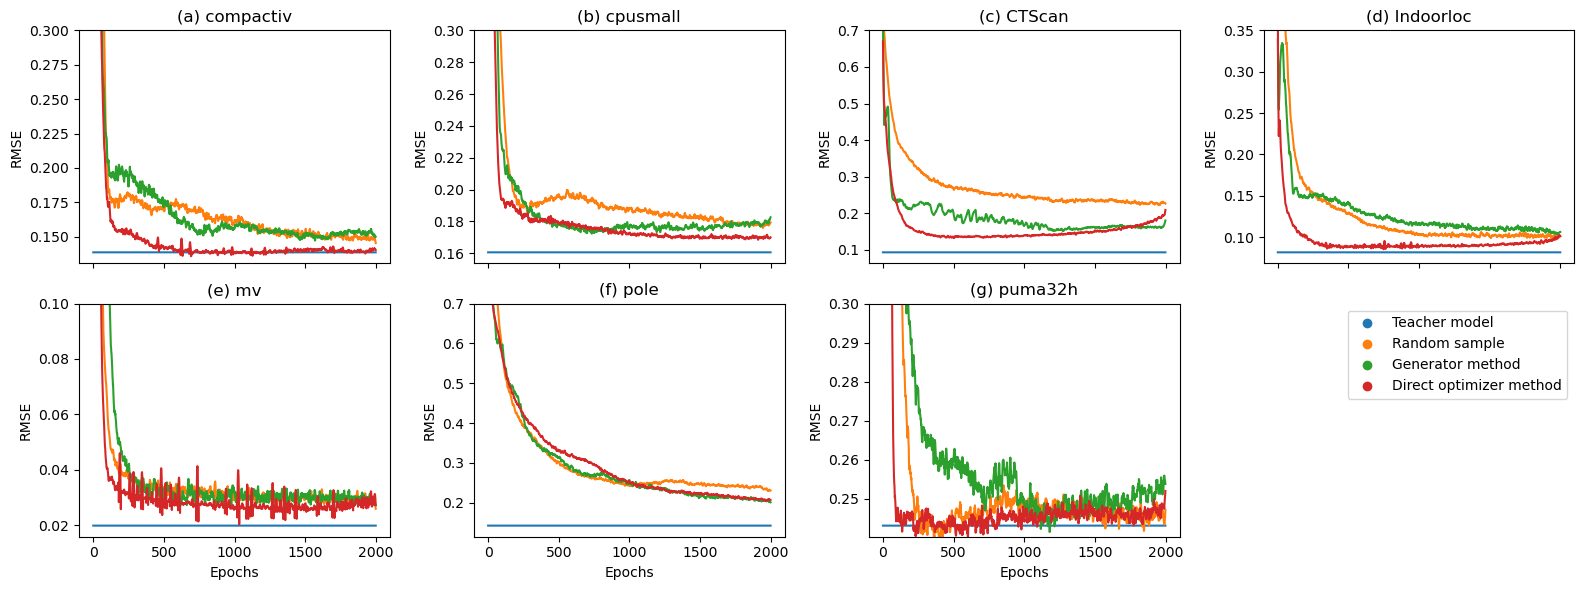

In [323]:
from matplotlib.pyplot import figure
from scipy.signal import savgol_filter

fig, axs = plt.subplots(2, 4, sharex=True, figsize=(16, 6))
#fig.text(0.5, 0, 'Epochs', ha='center')
#fig.text(0.04, 0.33, 'RMSE', va='center', rotation='vertical')
#fig.text(0.04, 0.66, 'RMSE', va='center', rotation='vertical')

datasets = ['compactiv', 'cpusmall', 'CTScan', 'Indoorloc', 'mv', 'pole', 'puma32h']
label = 'abcdefg'
teacher_RMSE = [0.1387, 0.1606, 0.0935, 0.0817, 0.0198, 0.1426, 0.2431]
y_lim = [0.3, 0.3, 0.7, 0.35, 0.1, 0.7, 0.3]
student_size = 50
plot_step = 1

for i in range(len(datasets)):
    row = i//4
    col = i%4
    axs[row, col].set_title(f"({label[i]}) {datasets[i]}")
    
    # teacher model
    axs[row, col].plot(np.arange(0, 2000, plot_step), np.ones(2000//plot_step)*teacher_RMSE[i], label='Teacher model')
    
    # baseline model
    valid_loss = np.load(f"plots\\baseline_model\\S_{student_size}_{datasets[i]}_valid_loss.npy")
    RMSE = np.sqrt(valid_loss)
    RMSE = savgol_filter(RMSE, 15, 2)
    axs[row, col].plot(np.arange(0, 2000, plot_step), RMSE[::plot_step], label='Random sample')
    
    # Generator model
    valid_loss = np.load(f"plots\\student_generator_model\\S_{student_size}_{datasets[i]}_g_valid_losses.npy")
    RMSE = np.sqrt(valid_loss)
    RMSE = savgol_filter(RMSE, 15, 2)
    axs[row, col].plot(np.arange(0, 2000, plot_step), RMSE[::plot_step], label='Generator method')
    
    # optimizer model
    valid_loss = np.load(f"plots\\student_optimizer_model\\S_{student_size}_{datasets[i]}_d_valid_loss.npy")
    RMSE = np.sqrt(valid_loss)
    RMSE = savgol_filter(RMSE, 15, 2)
    axs[row, col].plot(np.arange(0, 2000, plot_step), RMSE[::plot_step], label='Direct optimizer method')
    
    #axs[row, col].set_xlabel('epochs')
    axs[row, col].set_ylabel('RMSE')
    if i > 3:
        axs[row, col].set_xlabel('Epochs')
    
    plot_range = y_lim[i] - teacher_RMSE[i]
    axs[row, col].set_ylim(teacher_RMSE[i] - plot_range*0.05, top=y_lim[i])

plt.tight_layout()
axs[1, 3].scatter(None, None, label='Teacher model')
axs[1, 3].scatter(None, None, label='Random sample')
axs[1, 3].scatter(None, None, label='Generator method')
axs[1, 3].scatter(None, None, label='Direct optimizer method')
axs[1, 3].legend()
axs[1, 3].axis('off')
#axs[1, 3].set_axis_off()

plt.savefig(f"plots\\S_{student_size}_RMSE_plots.png")

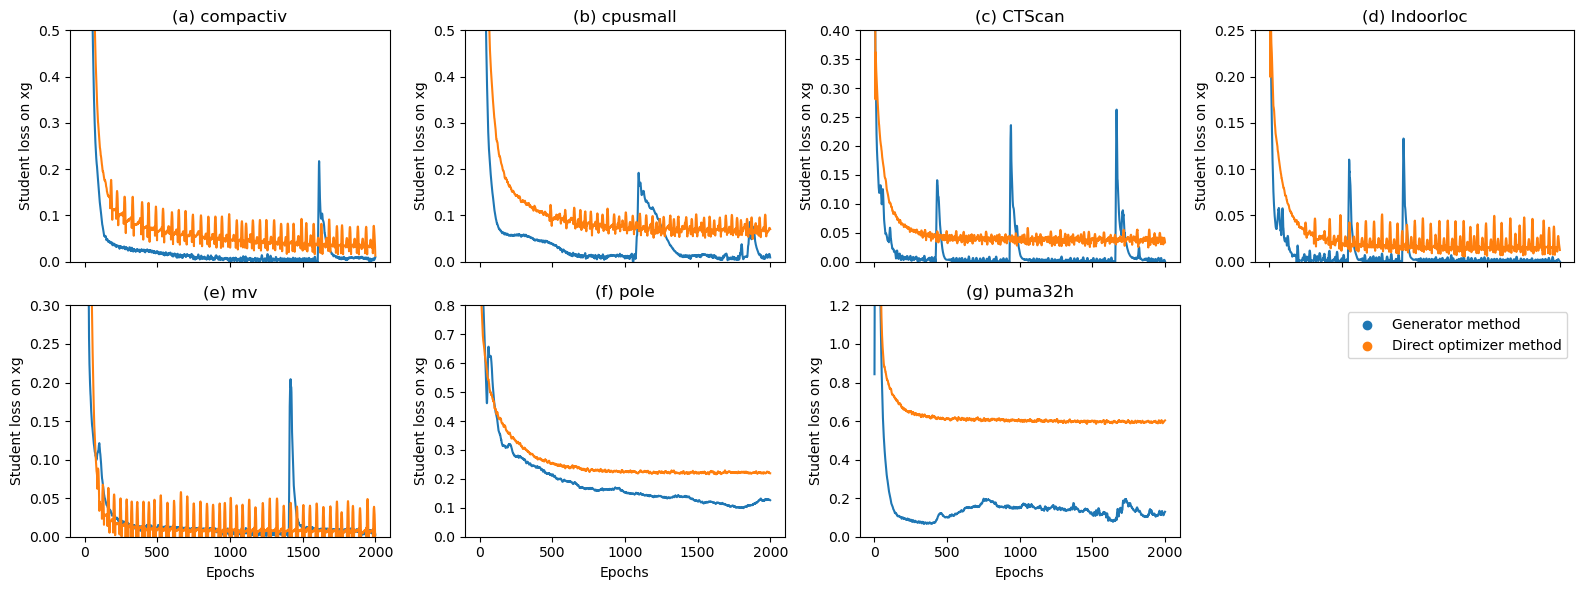

In [324]:
fig, axs = plt.subplots(2, 4, sharex=True, figsize=(16, 6))
#fig.text(0.5, 0.04, 'Epochs', ha='center')
#fig.text(0.04, 0.33, 'RMSE', va='center', rotation='vertical')
#fig.text(0.04, 0.66, 'RMSE', va='center', rotation='vertical')

datasets = ['compactiv', 'cpusmall', 'CTScan', 'Indoorloc', 'mv', 'pole', 'puma32h']
label = 'abcdefg'
y_lim = [0.5, 0.5, 0.4, 0.25, 0.3, 0.8, 1.2]
student_size = 50
plot_step = 1

for i in range(len(datasets)):
    row = i//4
    col = i%4
    axs[row, col].set_title(f"({label[i]}) {datasets[i]}")

    # baseline model
    valid_loss = np.load(f"plots\\student_generator_model\\S_{student_size}_{datasets[i]}_g2_gen_train_loss.npy")
    RMSE = np.sqrt(valid_loss)
    RMSE = savgol_filter(RMSE, 15, 2)
    axs[row, col].plot(np.arange(0, 2000, plot_step), RMSE[::plot_step], label='Generator method')
    
    # baseline model
    valid_loss = np.load(f"plots\\student_optimizer_model\\S_{student_size}_{datasets[i]}_d2_gen_train_loss.npy")
    RMSE = np.sqrt(valid_loss)
    RMSE = savgol_filter(RMSE, 15, 2)
    axs[row, col].plot(np.arange(0, 2000, plot_step), RMSE[::plot_step], label='Direct optimizer method')
    
    #axs[row, col].set_xlabel('epochs')
    axs[row, col].set_ylabel('Student loss on xg')
    if i > 3:
        axs[row, col].set_xlabel('Epochs')
    
    plot_range = y_lim[i] - teacher_RMSE[i]
    axs[row, col].set_ylim(0, top=y_lim[i])

plt.tight_layout()
axs[1, 3].scatter(None, None, label='Generator method')
axs[1, 3].scatter(None, None, label='Direct optimizer method')
axs[1, 3].legend()
axs[1, 3].axis('off')
#axs[1, 3].set_axis_off()

plt.savefig(f"plots\\S_{student_size}_genloss_plots.png")